# Note: open this notebook with colab

In [21]:
# Install PyTorch, PyTorch Lightning, and PyTorch Forecasting
!pip install pytorch-lightning
!pip install pytorch-forecasting
!pip install torch


# Data import and preparation

In [91]:
import torch
import pandas as pd
import numpy as np

In [92]:
data_train = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/train_preprocessed.csv")

In [93]:
data_train.isna().sum()

,0
id,0
valeur_NO2,0
valeur_CO,0
valeur_O3,0
valeur_PM10,0
valeur_PM25,0
is_holiday,0
is_jour_ferie,0
precipitation,0
wind_speed,0


In [94]:
data_train.fillna(-1, inplace=True)

In [100]:
data_train["id"] = pd.to_datetime(data_train["id"])
features = ['id', 'is_holiday', 'car_flow', 'precipitation',
       'wind_speed', 'temperature', 'humidity', 'pressure', 'visibility',
       'global_solar_radiation', 'Year', 'is_weekend', 'DayOfYear',
       'HourOfDay', 'DayOfYear_sin', 'DayOfYear_cos', 'HourOfDay_sin',
       'HourOfDay_cos', 'Weekday_sin', 'Weekday_cos']
data_train["location"] = "Montsouris"
data_train['time_idx'] = ((data_train['id'] - data_train['id'].min()).dt.total_seconds() // 3600).astype("int")
data_train.head()

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,is_holiday,is_jour_ferie,precipitation,wind_speed,...,HourOfDay,Weekday,DayOfYear_sin,DayOfYear_cos,HourOfDay_sin,HourOfDay_cos,Weekday_sin,Weekday_cos,location,time_idx
0,2020-01-01 00:00:00,42.9,0.718000,15.7,73.1,64.4,1,0,0.0,1.5,...,0,2,0.017213,0.999852,0.000000,1.000000,0.974928,-0.222521,Montsouris,0
1,2020-01-01 01:00:00,33.6,0.587000,10.1,74.8,66.0,1,0,0.0,2.6,...,1,2,0.017213,0.999852,0.258819,0.965926,0.974928,-0.222521,Montsouris,1
2,2020-01-01 02:00:00,29.3,0.400655,5.1,51.0,44.9,1,0,0.0,1.9,...,2,2,0.017213,0.999852,0.500000,0.866025,0.974928,-0.222521,Montsouris,2
3,2020-01-01 03:00:00,30.5,0.246000,7.2,27.7,25.1,1,0,0.0,1.8,...,3,2,0.017213,0.999852,0.707107,0.707107,0.974928,-0.222521,Montsouris,3
4,2020-01-01 04:00:00,29.3,0.204000,8.3,15.3,13.6,1,0,0.0,2.2,...,4,2,0.017213,0.999852,0.866025,0.500000,0.974928,-0.222521,Montsouris,4


In [1]:
max_encoder_length = 7 * 24
max_prediction_length = 504  # Forecast 504 hours into the future

In [97]:
from pytorch_forecasting import TimeSeriesDataSet

In [102]:
# Step 1: Define the split point
split_idx = int(data_train['time_idx'].max() * 0.9)

# Step 2: Split into training and validation sets
train_data = data_train[data_train["time_idx"] <= split_idx]
test_data = data_train[data_train["time_idx"] > split_idx]

if "car_flow" in features:
  features.remove("car_flow")

# Step 3: Create TimeSeriesDataSets for train and validation
train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25", "car_flow"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet(
    test_data,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25", "car_flow"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Model

## Train - validation first training

In [103]:
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=64, num_workers=8)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=8)

In [104]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE

# Define TFT model
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,  # You may adjust this
    hidden_size=16,  # Size of the network layers
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[1, 1, 1, 1, 1],
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in model: {tft.size()/1e3:.1f}k")


Number of parameters in model: 53.8k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

In [105]:
from lightning.pytorch import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger(save_dir="/content/drive/MyDrive/lighting_logs")


In [106]:
from lightning.pytorch import Trainer

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

trainer = Trainer(max_epochs=3, logger=tb_logger)
trainer.fit(tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


## Second training with full data (train + val)

In [107]:
from lightning.pytorch import Trainer

full_train_data = TimeSeriesDataSet(
    data_train,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25", "car_flow"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

full_train_dataloader = full_train_data.to_dataloader(train=True, batch_size=64, num_workers=8)
trainer = Trainer(max_epochs=3,logger=tb_logger)
# Resume training with the new combined dataloader
trainer.fit(tft,
            train_dataloaders=full_train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/lighting_logs/lightning_logs/version_1/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
-

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [109]:
torch.save(tft.state_dict(), "/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/tft_final.json")
# tft.load_state_dict(torch.load("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/tft.json", weights_only=True)) # Careful no car flow

 ## Predict for new data

In [110]:
encoder_data = data_train[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

test_data = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/test_preprocessed.csv")
test_data["id"] = pd.to_datetime(test_data["id"])
decoder_data = test_data.copy()
decoder_data["location"] = "Montsouris"
decoder_data['time_idx'] = ((decoder_data['id'] - decoder_data['id'].min()).dt.total_seconds() // 3600).astype("int") + data_train["time_idx"].max() + 1

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_prediction_data.ffill(inplace=True)

In [111]:
new_predictions = tft.predict(new_prediction_data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


In [112]:
new_predictions[0][0].cpu().numpy().shape

(504,)

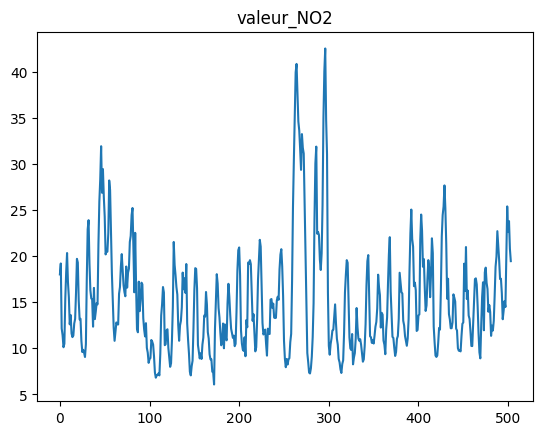

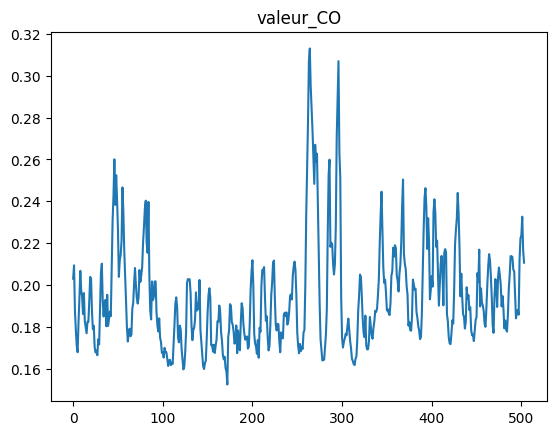

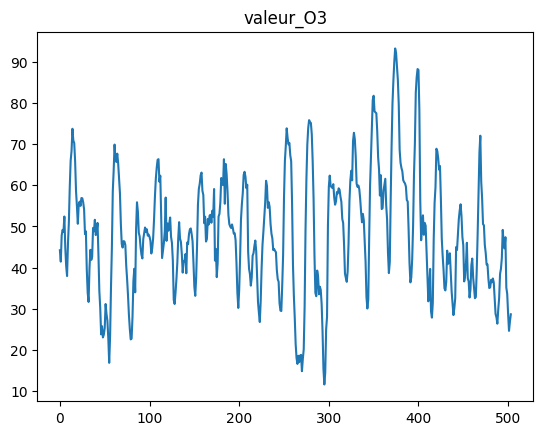

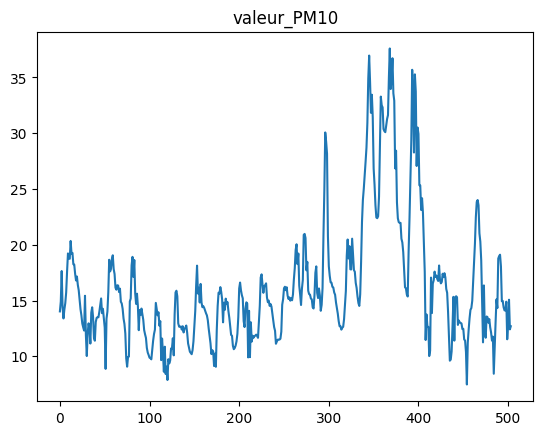

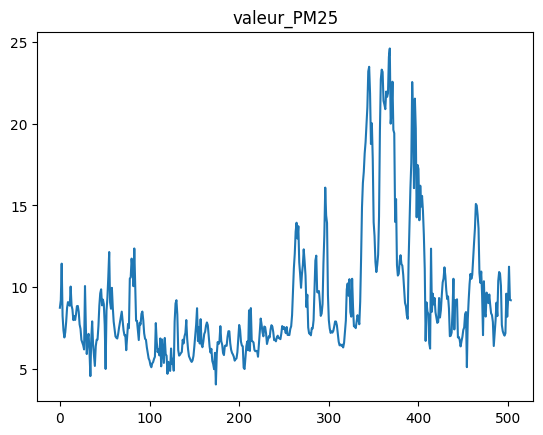

In [113]:
import matplotlib.pyplot as plt
targets = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]

for i, element in enumerate(new_predictions):
  plt.plot(element[0].cpu().numpy())
  plt.title(targets[i])
  plt.show()

In [114]:
test_data = test_data[["id"]]

for i, element in enumerate(new_predictions):
  test_data[targets[i]] = element[0].cpu().numpy()

test_data

<ipython-input-114-af6cf86083e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[targets[i]] = element[0].cpu().numpy()
<ipython-input-114-af6cf86083e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[targets[i]] = element[0].cpu().numpy()
<ipython-input-114-af6cf86083e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2024-09-03 23:00:00,18.008455,0.203046,44.220009,14.025316,8.728474
1,2024-09-04 00:00:00,19.194010,0.209419,41.451672,14.906204,9.185435
2,2024-09-04 01:00:00,12.152975,0.187717,47.818531,17.644953,11.429523
3,2024-09-04 02:00:00,11.421848,0.178506,49.174973,14.393028,8.228388
4,2024-09-04 03:00:00,10.113528,0.170941,48.693211,13.394511,7.332865
...,...,...,...,...,...,...
499,2024-09-24 18:00:00,25.380606,0.222334,33.632042,11.527310,8.179235
500,2024-09-24 19:00:00,22.598026,0.223790,28.733402,12.809429,9.245478
501,2024-09-24 20:00:00,23.784708,0.232656,24.647615,15.072096,11.240565
502,2024-09-24 21:00:00,20.776497,0.216545,26.851320,12.417898,9.211018


In [118]:
import sys
sys.path.append('/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project')
from utils.preprocessing import clean_for_submission

submission = clean_for_submission(test_data)
submission.to_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/submissions/matt_tft.csv", index=False)